# Supervised Learning
The idea of this notebook is using different learning machines in order to see how good are timbral features to describe musical genres. 
The data used is extracted from the GTZAN dataset: mfcc using gaussian windows with 60% overlapping. The features are the mean of the mfcc and the flattened covariance matrix for a total of 250 features

In [1]:
import pandas as pd 
from sklearn.tree import DecisionTreeClassifier
import numpy as np
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression
from numpy import interp
from sklearn import preprocessing,manifold
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import load_iris
from sklearn.metrics import precision_recall_fscore_support
from sklearn.preprocessing import OneHotEncoder, label_binarize
from sklearn.model_selection import train_test_split, StratifiedKFold
#from sklearn.metrics import roc_curve, roc_auc_score, plot_roc_curve, auc

In [2]:
data = pd.read_csv("mfccToy2.csv",header=None)
data = pd.DataFrame(data).to_numpy()
data.shape

(300, 211)

Data preprocessing: Cleaning NaN and Normalizing without imposing a distribution

In [3]:
data = data[~np.isnan(data).any(axis=1)]
data.shape

target = data[:,-1]
X = data[:,:-1]
X_norm = (X-X.min(axis=0))/(X.max(axis=0)-X.min(axis=0))

In [10]:
def plotgenres(Xe,target,pred,title):
    fig, (ax1, ax2) = plt.subplots(1, 2)
    ax1.title.set_text('Real')
    ax2.title.set_text('Predicted')
    ax1.scatter(Xe[target==1,0],Xe[target==1,1],c="lightcoral",label="blues")
    ax1.scatter(Xe[target==2,0],Xe[target==2,1],c="teal",label="country")
    ax1.scatter(Xe[target==3,0],Xe[target==3,1],c="darkred",label="rock")
    ax2.scatter(Xe[pred==1,0],Xe[pred==1,1],c="lightcoral",label="blues")
    ax2.scatter(Xe[pred==2,0],Xe[pred==2,1],c="teal",label="country")
    ax2.scatter(Xe[pred==3,0],Xe[pred==3,1],c="darkred",label="rock")
    handles, labels = ax1.get_legend_handles_labels()
    fig.legend(handles, labels, loc='lower center')
    fig.suptitle(title)
    plt.show()

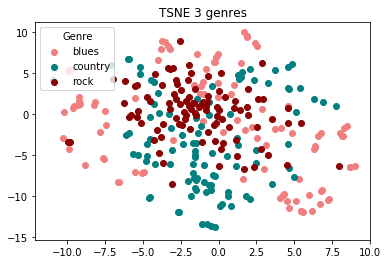

In [11]:
Xe= manifold.TSNE( metric='euclidean', method='barnes_hut').fit_transform(X_norm)
fig,ax=plt.subplots()
ax.scatter(Xe[target==1,0],Xe[target==1,1],c="lightcoral",label="blues")
ax.scatter(Xe[target==2,0],Xe[target==2,1],c="teal",label="country")
ax.scatter(Xe[target==3,0],Xe[target==3,1],c="darkred",label="rock")
plt.legend(loc='upper left',title="Genre")
plt.title('TSNE 3 genres')
plt.show()

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X_norm, target, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [14]:
Xe_test= manifold.TSNE( metric='euclidean', method='barnes_hut').fit_transform(X_test)

## Classifiers

### Logistic Regression

In [15]:
logistic = LogisticRegression(max_iter = 100000)
logistic.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100000,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

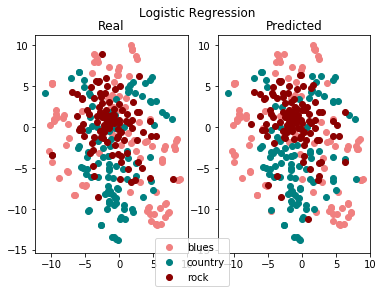

In [16]:
pred = logistic.predict(X_norm)
plotgenres(Xe,target,pred,"Logistic Regression")

In [17]:
pred = logistic.predict(X_test)
scores = precision_recall_fscore_support(y_test, pred,average='micro')
print('Precision:',scores[0])
print('Recall:',scores[1])
print('F1 Score:',scores[2])

Precision: 0.7166666666666667
Recall: 0.7166666666666667
F1 Score: 0.7166666666666667


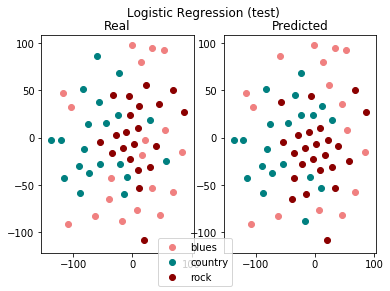

In [18]:
plotgenres(Xe_test,y_test,pred,"Logistic Regression (test)")

## Decision Tree

In [19]:
clf = DecisionTreeClassifier(max_depth = 5)
clf.fit(X_train,y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=5,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

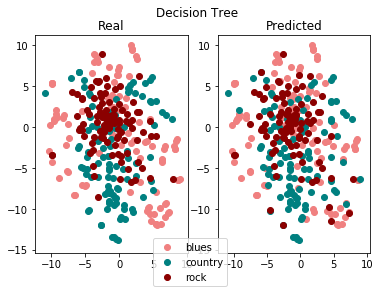

In [20]:
pred = clf.predict(X_norm)
plotgenres(Xe,target,pred,"Decision Tree")

In [21]:
pred = clf.predict(X_test)
scores = precision_recall_fscore_support(y_test, pred,average='micro')
print('Precision:',scores[0])
print('Recall:',scores[1])
print('F1 Score:',scores[2])

Precision: 0.5833333333333334
Recall: 0.5833333333333334
F1 Score: 0.5833333333333334


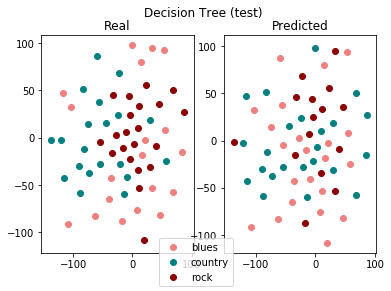

In [22]:
plotgenres(Xe_test,y_test,pred,"Decision Tree (test)")

## Support vector machine

Kernels:
* Lineal
* Polynomial
* Radial base

In [23]:
clf2 = svm.SVC(kernel = 'rbf')
clf2.fit(X_train,y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

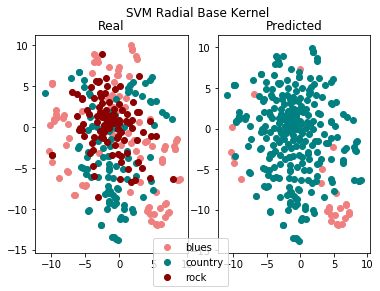

In [24]:
pred = clf2.predict(X_norm)
plotgenres(Xe,target,pred,"SVM Radial Base Kernel")

In [25]:
pred = clf2.predict(X_test)
scores = precision_recall_fscore_support(y_test, pred,average='micro')
print(scores)
print('Precision:',scores[0])
print('Recall:',scores[1])
print('F1 Score:',scores[2])

(0.4, 0.4, 0.4000000000000001, None)
Precision: 0.4
Recall: 0.4
F1 Score: 0.4000000000000001


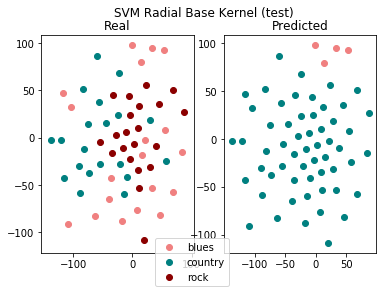

In [26]:
plotgenres(Xe_test,y_test,pred,"SVM Radial Base Kernel (test)")

In [27]:
clf2 = svm.SVC(kernel = 'linear')
clf2.fit(X_train,y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

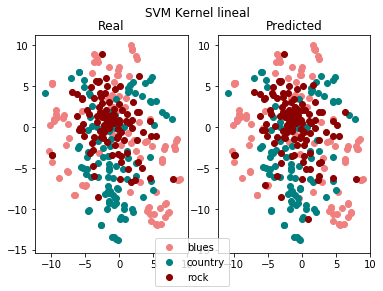

In [28]:
pred = clf2.predict(X_norm)
plotgenres(Xe,target,pred,"SVM Kernel lineal")

In [29]:
pred = clf2.predict(X_test)
scores = precision_recall_fscore_support(y_test, pred,average='micro')
print('Precision:',scores[0])
print('Recall:',scores[1])
print('F1 Score:',scores[2])

Precision: 0.7666666666666667
Recall: 0.7666666666666667
F1 Score: 0.7666666666666667


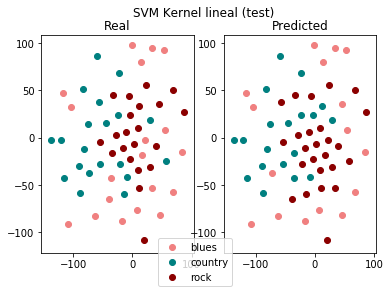

In [30]:
plotgenres(Xe_test,y_test,pred,"SVM Kernel lineal (test)")

In [31]:
clf2 = svm.SVC(kernel = 'poly',degree=3)
clf2.fit(X_train,y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='poly', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

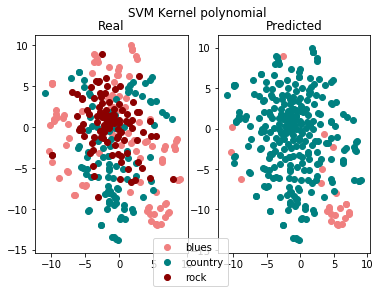

In [32]:
pred = clf2.predict(X_norm)
plotgenres(Xe,target,pred,"SVM Kernel polynomial")

In [33]:
pred = clf2.predict(X_test)
scores = precision_recall_fscore_support(y_test, pred,average='micro')
print('Precision:',scores[0])
print('Recall:',scores[1])
print('F1 Score:',scores[2])

Precision: 0.4
Recall: 0.4
F1 Score: 0.4000000000000001


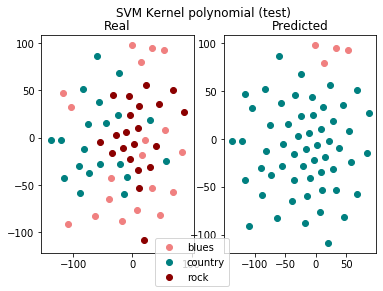

In [34]:
plotgenres(Xe_test,y_test,pred,"SVM Kernel polynomial (test)")

## Multilayer Perceptron

* Hidden layers: $L = 1,...,3$
* Number of neurons in the hidden layers: $l_i = 1,2,3$
* Learning rate: 0.2,0.5,0.9

In [35]:
learning_rate = [0.2,0.5,0.9]
nn =  MLPClassifier(hidden_layer_sizes=(1,1,1), learning_rate_init=.2)
nn.fit(X_train,y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(1, 1, 1), learning_rate='constant',
              learning_rate_init=0.2, max_iter=200, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=None, shuffle=True, solver='adam', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

In [42]:
learning_rate, activation = 0.2, 'relu'
error = 0
# Choose best performance with combinations of activations and learning rate
for act in ['relu','tanh','logistic']:
    for lr in [0.002,0.005,0.009,0.008,0.0002,0.0005,0.0009,0.0008]:
        nn =  MLPClassifier(hidden_layer_sizes=(100,100,100,100,100),activation=act, learning_rate_init=lr)
        nn.fit(X_train,y_train)
        err = np.sum(nn.predict(X_val) == y_val)/len(y_val)
        print(act,lr,err)
        if(err > error):
            learning_rate, activation, error = lr,act,err
nn =  MLPClassifier(hidden_layer_sizes=(100,100,100,100,100),activation=activation, learning_rate_init=learning_rate)
nn.fit(X_train,y_train)

relu 0.002 0.625
relu 0.005 0.6458333333333334
relu 0.009 0.625
relu 0.008 0.6458333333333334
relu 0.0002 0.625
relu 0.0005 0.6458333333333334
relu 0.0009 0.7083333333333334
relu 0.0008 0.7083333333333334
relu 0.02 0.625
relu 0.05 0.3541666666666667
relu 0.09 0.3125
relu 0.08 0.3333333333333333
tanh 0.002 0.5833333333333334
tanh 0.005 0.3125
tanh 0.009 0.3125
tanh 0.008 0.5
tanh 0.0002 0.6041666666666666
tanh 0.0005 0.625
tanh 0.0009 0.6458333333333334
tanh 0.0008 0.6041666666666666
tanh 0.02 0.3541666666666667
tanh 0.05 0.3541666666666667
tanh 0.09 0.3541666666666667
tanh 0.08 0.3541666666666667
logistic 0.002 0.3125
logistic 0.005 0.3125
logistic 0.009 0.3125
logistic 0.008 0.3333333333333333
logistic 0.0002 0.3541666666666667
logistic 0.0005 0.3541666666666667
logistic 0.0009 0.3541666666666667
logistic 0.0008 0.3333333333333333
logistic 0.02 0.3333333333333333
logistic 0.05 0.3333333333333333
logistic 0.09 0.3125
logistic 0.08 0.3333333333333333


MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(100, 100, 100, 100, 100),
              learning_rate='constant', learning_rate_init=0.0009, max_iter=200,
              momentum=0.9, n_iter_no_change=10, nesterovs_momentum=True,
              power_t=0.5, random_state=None, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

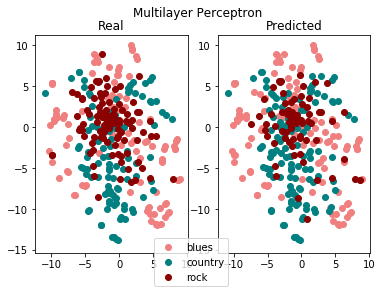

0.6179421665588203


In [37]:
pred = nn.predict(X_norm)
plotgenres(Xe,target,pred,"Multilayer Perceptron")
print(nn.loss_)

In [38]:
pred = nn.predict(X_test)
scores = precision_recall_fscore_support(y_test, pred,average='micro')
print('Precision:',scores[0])
print('Recall:',scores[1])
print('F1 Score:',scores[2])

Precision: 0.5666666666666667
Recall: 0.5666666666666667
F1 Score: 0.5666666666666667


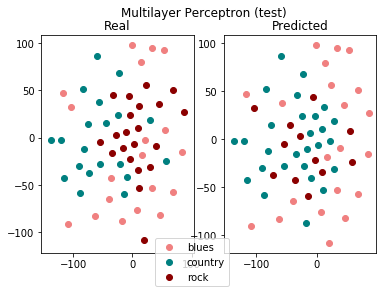

In [39]:
plotgenres(Xe_test,y_test,pred,"Multilayer Perceptron (test)")

| Parámetro | Logistic  Regression | Decision Tree | SVM Linear | SVM rbf | SVM Poly | Multilayer Perceptron |
|:---------:|:--------------------:|:-------------:|:----------:|:-------:|:--------:|:---------------------:|
| Precision |         0.933        |     0.883     |    0.95    |   0.6   |   0.516  |         0.933         |
|   Recall  |         0.933        |     0.883     |    0.95    |   0.6   |   0.516  |         0.933         |
|     F1    |         0.933        |     0.883     |    0.95    |   0.6   |   0.516  |         0.933         |